EV Curve and Density of State Calculations

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

from ase import Atoms
from ase.build import bulk
from ase.calculators.castep import Castep
from ase.visualize import view

import time

os.environ["CASTEP_COMMAND"]="/usr/local/bin/castep.serial"       # command to execute CASTEP
os.environ["CASTEP_PP_PATH"] =os.getcwd()+"/PSPOT"                # path to potential files
os.environ["OMP_NUM_THREADS"]="1"                                 # needed for speed

### Setup the Castep calculator and structure

In [2]:
# create a Castep calculator object
calc = Castep(directory="CASTEP_03/calcs",ecut=250,kpts=[4,4,4])

# Construct a primitive fcc Al cell using ase.build.bulk and set the calculator
struc = bulk("Al",crystalstructure='fcc',a=4.04)
calc.cell.symmetry_generate=True
calc.cell.species_pot = ('Al', 'Al_LDA.usp')
struc.set_calculator(calc)


struc.get_potential_energy()

-109.7314821683

### FCC

### Calculate E-V curves to get optimized lattice parameter

To get the ideal lattice parameter, we vary `a` in a certain range and calculate the potential energy at each point. The minimum of this curve corresponds to the ideal lattice parameter for the given structure.

In [6]:
calc = Castep(directory="CASTEP_03/calcs",ecut=250,kpts=[4,4,4])
a0_sc = 2.7
a0_bcc = 3.2
a0_fcc = 4.0
a0_diamond = 5.8

min_perc = 0.9
max_perc = 1.1

def get_a_range(a0, min_perc, max_perc):
    a_range = np.linspace(a0*min_perc,a0*max_perc,15)
    return a_range

a_range_sc = get_a_range(a0_sc, min_perc, max_perc)
a_range_bcc = get_a_range(a0_bcc, min_perc, max_perc)
a_range_fcc = get_a_range(a0_fcc, min_perc, max_perc)
a_range_diamond = get_a_range(a0_diamond, min_perc, max_perc)

energies_SC = []
energies_BCC = []
energies_FCC = []
energies_DIAMOND = []

print("%s     %s"%("a[A]","en[eV]"))

def get_energies(a_range, crys_struc, energies):
    print(crys_struc)
    for a in a_range:

        struc = bulk("Al",crystalstructure=crys_struc,a=a)
        calc.cell.symmetry_generate=True
        calc.cell.species_pot = ('Al', 'Al_LDA.usp')
        struc.set_calculator(calc)
        en = struc.get_potential_energy()
        print("%.5f %.5f"%(a,en))
        energies.append(en)
        
# get_energies(get_a_range(a0_sc, min_perc, max_perc), 'sc', energies_SC)
# get_energies(get_a_range(a0_bcc, min_perc, max_perc), 'bcc', energies_BCC)
# get_energies(get_a_range(a0_fcc, min_perc, max_perc), 'fcc', energies_FCC)
# get_energies(get_a_range(a0_diamond, min_perc, max_perc), 'diamond', energies_DIAMOND)

a[A]     en[eV]


### Initialise the structure

In [14]:
class structure:

    def __init__(self, crystal_structure, element, element_list, a0, energies, min_perc, max_perc):
        self.crystal_structure = crystal_structure
        self.element = element
        self.element_list = element_list
        self.a = float(a0)
        self.energies = energies
        self.min_perc = float(min_perc)
        self.max_perc = float(max_perc)

        # self.a_range = a_range
        # self.a_fine_range = a_fine_range

    # Instance method
        
    def get_energies(self):
        print("%s     %s"%("a[A]","en[eV]"))
        print(self.crystal_structure)
        for a in self.a_range:

            struc = bulk(self.element,crystalstructure=self.crystal_structure,a=a)
            calc.cell.symmetry_generate=True
            calc.param.spin_polarised=False
            for element in self.element_list:
                calc.cell.species_pot = (element, element+'_LDA.usp')
            struc.set_calculator(calc)
            en = struc.get_potential_energy()
            print("%.5f %.5f"%(a,en))
            self.energies.append(en)

    def get_L1o(self,a):
        # Function to return the L1o (CuAu) lattice
        # ele is the compound e.g. ele="TiSe"
        # a is the lattice parameter 

        # No. of atoms in the cell:
        nd = 2

        # set the cell:
        c= a*1.31 #fixed c/a ratio
        cell = [[a,0,0],
               [0,a,0],
               [0,0,c]]

        # positions of each atom:
        pos = [[0,0,0],
               [0.5,0.5,0.5]]

        atoms = Atoms(self.element,cell=cell,pbc=True)
        atoms.positions[1, :] = [a / 2, a/2, c/2]
        return atoms
   
    def get_energies_L1o(self):
        print("%s     %s"%("a[A]","en[eV]"))
        print(self.crystal_structure)
        for a in self.a_range:

            struc = self.get_L1o(a)
            calc.cell.symmetry_generate=True
            calc.param.spin_polarised=False
            for element in self.element_list:
                calc.cell.species_pot = (element, element+'_LDA.usp')
            struc.set_calculator(calc)
            en = struc.get_potential_energy()
            print("%.5f %.5f"%(a,en))
            self.energies.append(en)
     
    def get_a_range(self):
        a_range = np.linspace(self.a*self.min_perc,self.a*self.max_perc,15)
        return a_range

    def get_a_fine_range(self):
        a_fine_range = np.linspace(self.a*self.min_perc,self.a*self.max_perc,10000)
        return a_fine_range
    
    def get_setup(self):
        self.a_range = self.get_a_range()
        self.a_fine_range = self.get_a_fine_range()
        self.get_energies()
    
    def get_setup_L1o(self):
        self.a_range = self.get_a_range()
        self.a_fine_range = self.get_a_fine_range()
        self.get_energies_L1o()
        
    def get_setup2(self):
        self.a_range = self.get_a_range()
        self.a_fine_range = self.get_a_fine_range()
    
    def get_fit(self):
        self.p = np.polyfit(self.a_range,self.energies,deg=4)
        self.coeff = np.poly1d(self.p)
    
    def get_plots(self):
        plt.plot(self.a_range,self.energies,"o",label=self.crystal_structure+" Raw Data")
        plt.plot(self.a_fine_range,self.coeff(self.a_fine_range),"--",label=self.crystal_structure+" polynomial fit")
    
    def get_a_min(self):
        self.i_min = np.argmin(self.coeff(self.a_fine_range))
        self.a_min = self.a_fine_range[self.i_min]
        self.emin = self.coeff(self.a_fine_range)[self.i_min]
        self.a_range_iterate = np.linspace(self.a_min*self.min_perc,self.a_min*self.max_perc,15)
        self.a_fine_range_iterate = np.linspace(self.a_min*self.min_perc,self.a_min*self.max_perc,10000)
        self.energies_iterate = []
        
    def get_energies_iterate(self):
        print("%s     %s"%("a[A]","en[eV]"))
        print(self.crystal_structure)
        for a in self.a_range_iterate:

            struc = bulk(self.element,crystalstructure=self.crystal_structure,a=a)
            calc.cell.symmetry_generate=True
            # calc.param.spin_polarised=False
            for element in self.element_list:
                calc.cell.species_pot = (element, element+'_LDA.usp')
            struc.set_calculator(calc)
            en = struc.get_potential_energy()
            print("%.5f %.5f"%(a,en))
            self.energies_iterate.append(en)

    def get_fit_iterate(self):
        self.p_iterate = np.polyfit(self.a_range_iterate,self.energies_iterate,deg=4)
        self.coeff_iterate = np.poly1d(self.p_iterate)
    
    def get_plots_iterate(self):
        plt.plot(self.a_range_iterate,self.energies_iterate,"o",label=self.crystal_structure+" Raw Data")
        plt.plot(self.a_fine_range_iterate,self.coeff_iterate(self.a_fine_range_iterate),"--",label=self.crystal_structure+" polynomial fit")


#     def description(self):
#         return f"{self.name} is {self.age} years old"

#     # Another instance method
#     def speak(self, sound):
#         return f"{self.name} says {sound}"

In [33]:
ele_a = 'Al'
ele_a_list = [ele_a]
ele_b = 'Si'
ele_b_list = [ele_b]
ele_c = 'Ti'
ele_c_list = [ele_c]
a_a0_sc, a_a0_bcc, a_a0_fcc, a_a0_diamond = 2.7, 3.2, 4.0, 5.8
b_a0_sc, b_a0_bcc, b_a0_fcc, b_a0_diamond = 2.51, 3.02, 3.84, 5.43
c_a0_sc, c_a0_bcc, c_a0_fcc, c_a0_diamond = 2.62, 3.15, 3.87, 5.55


# 2.687713771377138 3.215777577757776 3.988758875887589 5.9487848784878485
# 2.5088703870387037 3.025829182918292 3.834738673867387 5.400077707770777
# 2.614261626162617 3.1904815481548154 3.9398604860486053 5.592572757275728
min_perc = 0.9
max_perc = 1.1

In [34]:
Al_sc = structure('sc',ele_a,ele_a_list,a_a0_sc,[], min_perc, max_perc)
Al_bcc = structure('bcc',ele_a,ele_a_list,a_a0_bcc,[], min_perc, max_perc)
Al_fcc = structure('fcc',ele_a,ele_a_list,a_a0_fcc,[], min_perc, max_perc)
Al_diamond = structure('diamond',ele_a,ele_a_list,a_a0_diamond,[], min_perc, max_perc)

Si_sc = structure('sc',ele_b,ele_b_list,b_a0_sc,[], min_perc, max_perc)
Si_bcc = structure('bcc',ele_b,ele_b_list,b_a0_bcc,[], min_perc, max_perc)
Si_fcc = structure('fcc',ele_b,ele_b_list,b_a0_fcc,[], min_perc, max_perc)
Si_diamond = structure('diamond',ele_b,ele_b_list,b_a0_diamond,[], min_perc, max_perc)

Ti_sc = structure('sc',ele_c,ele_c_list,c_a0_sc,[], min_perc, max_perc)
Ti_bcc = structure('bcc',ele_c,ele_c_list,c_a0_bcc,[], min_perc, max_perc)
Ti_fcc = structure('fcc',ele_c,ele_c_list,c_a0_fcc,[], min_perc, max_perc)
Ti_diamond = structure('diamond',ele_c,ele_c_list,c_a0_diamond,[], min_perc, max_perc)


In [35]:
print('Aluminium')
Al_sc.get_setup()
Al_bcc.get_setup()
Al_fcc.get_setup()
Al_diamond.get_setup()

print('Silicon')
Si_sc.get_setup()
Si_bcc.get_setup()
Si_fcc.get_setup()
Si_diamond.get_setup()

print('Titanium')
Ti_sc.get_setup()
Ti_bcc.get_setup()
Ti_fcc.get_setup()
Ti_diamond.get_setup()

Aluminium
a[A]     en[eV]
sc
2.43000 -108.82437
2.46857 -108.95824
2.50714 -109.06317
2.54571 -109.14239
2.58429 -109.19923
2.62286 -109.23568
2.66143 -109.25338
2.70000 -109.25672
2.73857 -109.24666
2.77714 -109.22504
2.81571 -109.19325
2.85429 -109.15282
2.89286 -109.10513
2.93143 -109.05138
2.97000 -108.99263
a[A]     en[eV]
bcc
2.88000 -109.14470
2.92571 -109.31268
2.97143 -109.44542
3.01714 -109.54794
3.06286 -109.62387
3.10857 -109.67569
3.15429 -109.70771
3.20000 -109.72179
3.24571 -109.71974
3.29143 -109.70395
3.33714 -109.67597
3.38286 -109.63784
3.42857 -109.59057
3.47429 -109.53576
3.52000 -109.47462
a[A]     en[eV]
fcc
3.60000 -109.21507
3.65714 -109.37614
3.71429 -109.50213
3.77143 -109.59662
3.82857 -109.66453
3.88571 -109.70861
3.94286 -109.73198
4.00000 -109.73722
4.05714 -109.72690
4.11429 -109.70328
4.17143 -109.66849
4.22857 -109.62475
4.28571 -109.57313
4.34286 -109.51564
4.40000 -109.45373
a[A]     en[eV]
diamond
5.22000 -216.61316
5.30286 -216.95143
5.38571 -217.2

/home/courseadmin/.conda/envs/imm-new/lib/python3.8/site-packages/ase/calculators/castep.py:1477: UserWarning: WARNING: /home/course45/Tuesday/CASTEP_03/calcs/castep.castep contains warnings
  warnings.warn('WARNING: %s contains warnings' % castep_file)
/home/courseadmin/.conda/envs/imm-new/lib/python3.8/site-packages/ase/calculators/castep.py:1479: UserWarning:  Warning: There are no empty bands for at least one kpoint and spin; this may

  warnings.warn(warning)
/home/courseadmin/.conda/envs/imm-new/lib/python3.8/site-packages/ase/calculators/castep.py:1479: UserWarning:           If this warning persists, you should consider increasing nextra_bands

  warnings.warn(warning)


6.02571 -3177.17465
6.10500 -3177.10534


### To store data, so that the object can be edited

In [36]:
for i in range(len(Al_diamond.energies)):
    Al_diamond.energies[i] = Al_diamond.energies[i]/2
for i in range(len(Si_diamond.energies)):
    Si_diamond.energies[i] = Si_diamond.energies[i]/2
for i in range(len(Ti_diamond.energies)):
    Ti_diamond.energies[i] = Ti_diamond.energies[i]/2
Al_sc_energies = Al_sc.energies
Al_bcc_energies = Al_bcc.energies
Al_fcc_energies = Al_fcc.energies
Al_diamond_energies = Al_diamond.energies
Si_sc_energies = Si_sc.energies
Si_bcc_energies = Si_bcc.energies
Si_fcc_energies = Si_fcc.energies
Si_diamond_energies = Si_diamond.energies
Ti_sc_energies = Ti_sc.energies
Ti_bcc_energies = Ti_bcc.energies
Ti_fcc_energies = Ti_fcc.energies
Ti_diamond_energies = Ti_diamond.energies

In [37]:
# sc.get_setup()
# bcc.get_setup()
# fcc.get_setup()
# diamond.get_setup()
Al_sc.get_fit()
Al_bcc.get_fit()
Al_fcc.get_fit()
Al_diamond.get_fit()
Si_sc.get_fit()
Si_bcc.get_fit()
Si_fcc.get_fit()
Si_diamond.get_fit()
Ti_sc.get_fit()
Ti_bcc.get_fit()
Ti_fcc.get_fit()
Ti_diamond.get_fit()

In [38]:
print('Aluminium')
Al_sc.get_a_min()
Al_bcc.get_a_min()
Al_fcc.get_a_min()
Al_diamond.get_a_min()

print('Silicon')
Si_sc.get_a_min()
Si_bcc.get_a_min()
Si_fcc.get_a_min()
Si_diamond.get_a_min()

print('Titanium')
Ti_sc.get_a_min()
Ti_bcc.get_a_min()
Ti_fcc.get_a_min()
Ti_diamond.get_a_min()
print(Al_sc.a_min,Al_bcc.a_min,Al_fcc.a_min, Al_diamond.a_min) 
print(Si_sc.a_min,Si_bcc.a_min,Si_fcc.a_min, Si_diamond.a_min) 
print(Ti_sc.a_min,Ti_bcc.a_min,Ti_fcc.a_min, Ti_diamond.a_min) 

Aluminium
Silicon
Titanium
2.6889558955895594 3.215777577757776 3.988758875887589 5.9487848784878485
2.5088703870387037 3.025829182918292 3.834738673867387 5.400077707770777
2.614261626162617 3.1904815481548154 3.9398604860486053 5.592572757275728


In [ ]:
# energy = np.asarray([-336.72184,-337.13643,-337.45783,-337.70078,-337.8726,-337.98163,-338.03535,-338.04121,-338.00505,-337.93314,-337.82861,-337.69904,-337.54739,-337.37739,-337.19275])
# Si_diamond.energies = energy

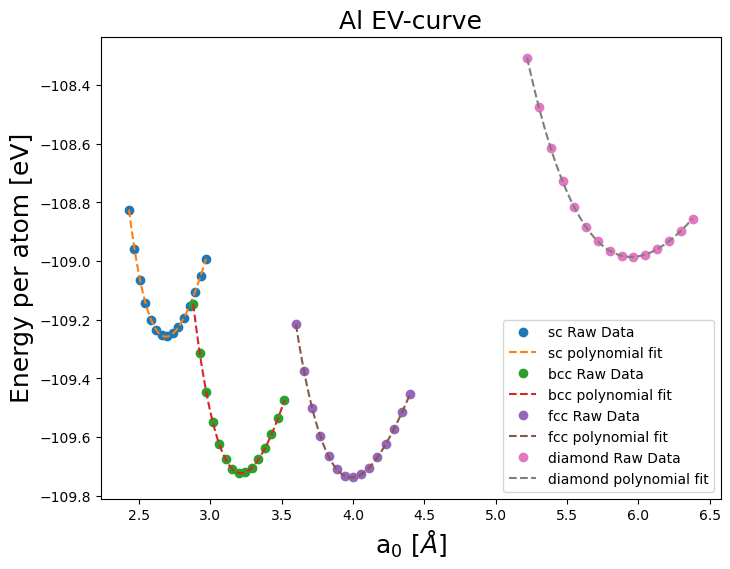

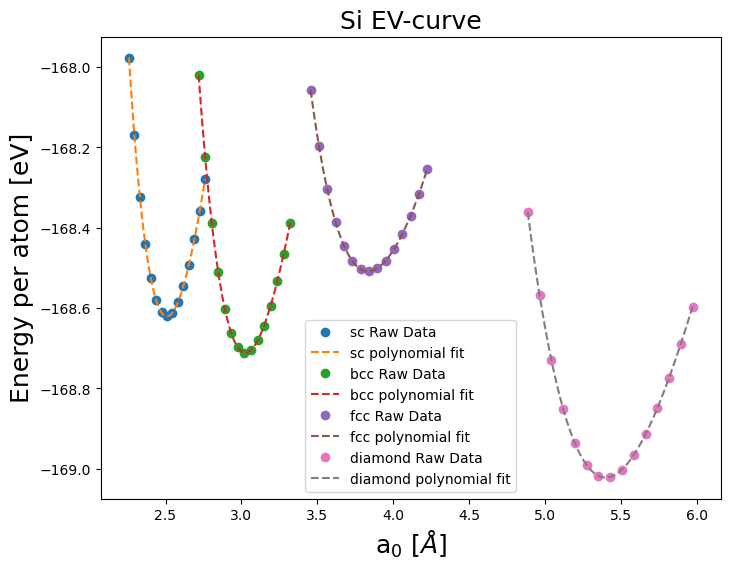

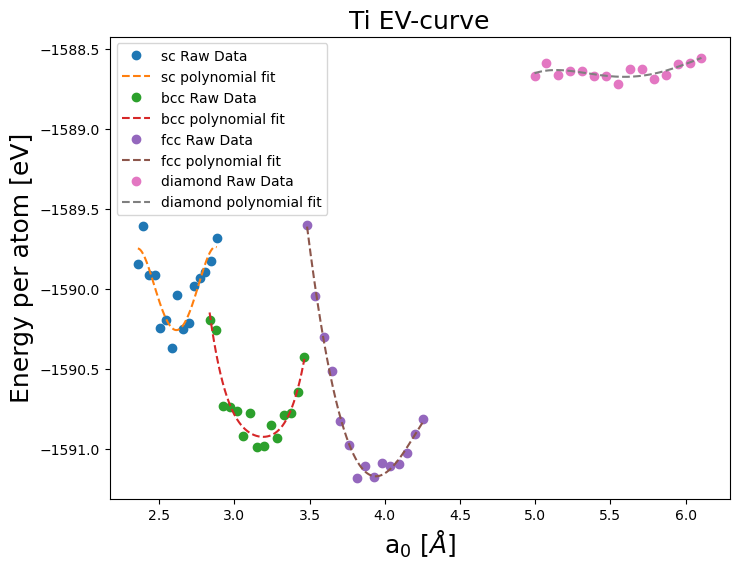

In [39]:
plt.figure(figsize=[8,6])
Al_sc.get_plots()
Al_bcc.get_plots()
Al_fcc.get_plots()
Al_diamond.get_plots()
plt.title("Al EV-curve",fontsize=18)
plt.xlabel("a$_0$ [$\AA$]",fontsize=18)
plt.ylabel("Energy per atom [eV]",fontsize=18)

plt.legend()
plt.savefig('Al Stabilities of structures.png')
plt.show()


plt.figure(figsize=[8,6])
Si_sc.get_plots()
Si_bcc.get_plots()
Si_fcc.get_plots()
Si_diamond.get_plots()
plt.title("Si EV-curve",fontsize=18)
plt.xlabel("a$_0$ [$\AA$]",fontsize=18)
plt.ylabel("Energy per atom [eV]",fontsize=18)

plt.legend()
plt.savefig('Si Stabilities of structures.png')
plt.show()


plt.figure(figsize=[8,6])
Ti_sc.get_plots()
Ti_bcc.get_plots()
Ti_fcc.get_plots()
Ti_diamond.get_plots()
plt.title("Ti EV-curve",fontsize=18)
plt.xlabel("a$_0$ [$\AA$]",fontsize=18)
plt.ylabel("Energy per atom [eV]",fontsize=18)

plt.legend()
plt.savefig('Ti Stabilities of structures.png')
plt.show()



In [ ]:
struc = bulk("Al",crystalstructure='fcc',a=3.99)
calc.cell.symmetry_generate=True
calc.cell.species_pot = ('Al', 'Al_LDA.usp')

calc = Castep("CASTEP_03/bs",
              task='bandstructure',
              bandpath=struc.cell.bandpath().interpolate(npoints=200),
              kpts=(4, 4, 4))
calc.cell.symmetry_generate=True  
calc.param.spin_polarised=False
# calc.cell.species_pot = ('Cu', 'Cu_LDA.usp') 
# calc.cell.species_pot = ('Ga', 'Ga_LDA.usp') 

struc.set_calculator(calc)
struc.get_total_energy() 
bs = struc.calc.band_structure()

bs.subtract_reference().plot()
plt.title('fcc-Al bandstructure')
plt.savefig('fcc-Al bandstructure')
plt.show()


struc = bulk("Si",crystalstructure='fcc',a=3.834738673867387)
calc.cell.symmetry_generate=True
calc.cell.species_pot = ('Si', 'Si_LDA.usp')

calc = Castep("CASTEP_03/bs",
              task='bandstructure',
              bandpath=struc.cell.bandpath().interpolate(npoints=200),
              kpts=(4, 4, 4))
calc.cell.symmetry_generate=True   
calc.param.spin_polarised=False
# calc.cell.species_pot = ('Cu', 'Cu_LDA.usp') 
# calc.cell.species_pot = ('Ga', 'Ga_LDA.usp') 

struc.set_calculator(calc)
struc.get_total_energy() 
bs = struc.calc.band_structure()

bs.subtract_reference().plot()
plt.title('fcc-Si bandstructure')
plt.savefig('fcc-Si bandstructure')
plt.show()

struc = bulk("Ti",crystalstructure='fcc',a=3.9398604860486053)
calc.cell.symmetry_generate=True
calc.cell.species_pot = ('Ti', 'Ti_LDA.usp')

calc = Castep("CASTEP_03/bs",
              task='bandstructure',
              bandpath=struc.cell.bandpath().interpolate(npoints=200),
              kpts=(4, 4, 4))
calc.cell.symmetry_generate=True  
calc.param.spin_polarised=False
# calc.cell.species_pot = ('Cu', 'Cu_LDA.usp') 
# calc.cell.species_pot = ('Ga', 'Ga_LDA.usp') 

struc.set_calculator(calc)
struc.get_total_energy() 
bs = struc.calc.band_structure()

bs.subtract_reference().plot()
plt.title('fcc-Ti bandstructure')
plt.savefig('fcc-Ti bandstructure')
plt.show()



In [28]:
ele_d = 'AlSi'
ele_d_list = ['Al','Si']
ele_e = 'AlTi'
ele_e_list = ['Al','Ti']
d_a0_rocksalt, d_a0_zincblende, d_a0_ceasiumchloride, d_a0_L1o = 5.1, 5.6, 3.1, 2.8
e_a0_rocksalt, e_a0_zincblende, e_a0_ceasiumchloride, e_a0_L1o = 5.1, 6.0, 3.04, 2.88

def L1o(ele,a):
    # Function to return the L1o (CuAu) lattice
    # ele is the compound e.g. ele="TiSe"
    # a is the lattice parameter 

    # No. of atoms in the cell:
    nd = 2

    # set the cell:
    c= a*1.31 #fixed c/a ratio
    cell = [[a,0,0],
           [0,a,0],
           [0,0,c]]

    # positions of each atom:
    pos = [[0,0,0],
           [0.5,0.5,0.5]]

    atoms = Atoms(ele,cell=cell,pbc=True)
    atoms.positions[1, :] = [a / 2, a/2, c/2]
    return atoms

AlSi_L1o_struc = L1o("AlSi",a=3.2)
AlTi_L1o_struc = L1o("AlTi",a=3.2)

AlSi_rocksalt = structure('rocksalt',ele_d,ele_d_list,d_a0_rocksalt,[], min_perc, max_perc)
AlSi_zincblende = structure('zincblende',ele_d,ele_d_list,d_a0_zincblende,[], min_perc, max_perc)
AlSi_ceasiumchloride = structure('cesiumchloride',ele_d,ele_d_list,d_a0_ceasiumchloride,[], min_perc, max_perc)
AlSi_L1o = structure('L1o',ele_d,ele_d_list,d_a0_L1o,[], min_perc, max_perc)

AlTi_rocksalt = structure('rocksalt',ele_e,ele_e_list,e_a0_rocksalt,[], min_perc, max_perc)
AlTi_zincblende = structure('zincblende',ele_e,ele_e_list,e_a0_zincblende,[], min_perc, max_perc)
AlTi_ceasiumchloride = structure('cesiumchloride',ele_e,ele_e_list,e_a0_ceasiumchloride,[], min_perc, max_perc)
AlTi_L1o = structure('L1o',ele_e,ele_e_list,e_a0_L1o,[], min_perc, max_perc)

In [29]:
AlSi_rocksalt.get_setup()
AlSi_zincblende.get_setup()
AlSi_ceasiumchloride.get_setup()
AlSi_L1o.get_setup_L1o()
AlTi_rocksalt.get_setup()
AlTi_zincblende.get_setup()
AlTi_ceasiumchloride.get_setup()
AlTi_L1o.get_setup_L1o()

a[A]     en[eV]
rocksalt
4.59000 -276.87809
4.66286 -277.27053
4.73571 -277.58461
4.80857 -277.82828
4.88143 -278.01017
4.95429 -278.13740
5.02714 -278.21584
5.10000 -278.25341
5.17286 -278.25417
5.24571 -278.22343
5.31857 -278.16679
5.39143 -278.08878
5.46429 -277.99264
5.53714 -277.88084
5.61000 -277.75545
a[A]     en[eV]
zincblende
5.04000 -276.55049
5.12000 -276.93048
5.20000 -277.23662
5.28000 -277.47651
5.36000 -277.65750
5.44000 -277.78635
5.52000 -277.86880
5.60000 -277.91079
5.68000 -277.91575
5.76000 -277.88996
5.84000 -277.83711
5.92000 -277.76043
6.00000 -277.66379
6.08000 -277.54979
6.16000 -277.42109
a[A]     en[eV]
cesiumchloride
2.79000 -276.68418
2.83429 -277.03182
2.87857 -277.30554
2.92286 -277.51560
2.96714 -277.66844
3.01143 -277.77026
3.05571 -277.82661
3.10000 -277.84592
3.14429 -277.84167
3.18857 -277.82359
3.23286 -277.79453
3.27714 -277.75075
3.32143 -277.68811
3.36571 -277.60643
3.41000 -277.50925
a[A]     en[eV]
L1o
2.52000 -277.22302
2.56000 -277.59893
2.60

In [30]:
AlSi_structures_list = [AlSi_rocksalt, AlSi_zincblende, AlSi_ceasiumchloride, AlSi_L1o]
AlTi_structures_list = [AlTi_rocksalt, AlTi_zincblende, AlTi_ceasiumchloride, AlTi_L1o]

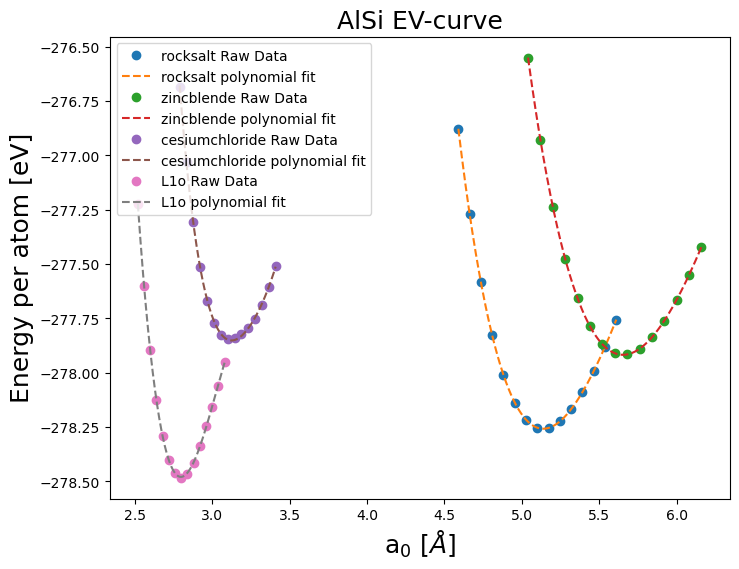

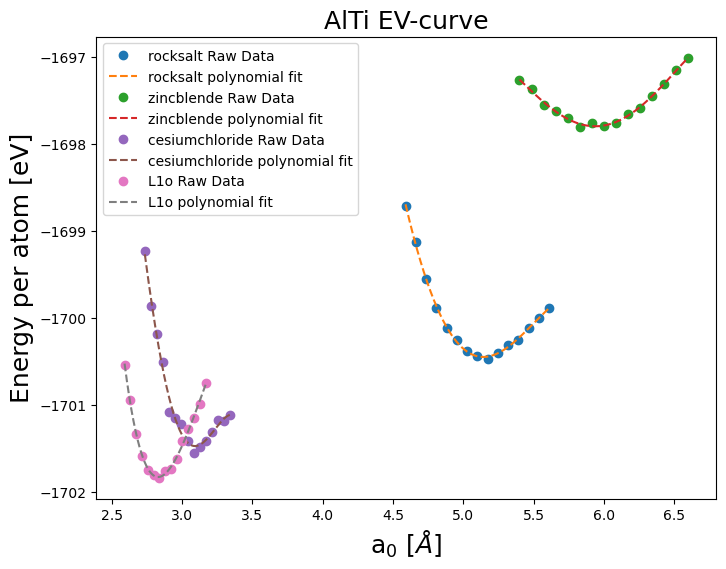

In [31]:
plt.figure(figsize=[8,6])
for i in AlSi_structures_list:
    i.get_fit()
    i.get_a_min()
    i.get_plots()
plt.title("AlSi EV-curve",fontsize=18)
plt.xlabel("a$_0$ [$\AA$]",fontsize=18)
plt.ylabel("Energy per atom [eV]",fontsize=18)

plt.legend()
plt.savefig('AlSi Stabilities of structures.png')
plt.show()

plt.figure(figsize=[8,6])
for i in AlTi_structures_list:
    i.get_fit()
    i.get_a_min()
    i.get_plots()
plt.title("AlTi EV-curve",fontsize=18)
plt.xlabel("a$_0$ [$\AA$]",fontsize=18)
plt.ylabel("Energy per atom [eV]",fontsize=18)

plt.legend()
plt.savefig('AlTi Stabilities of structures.png')
plt.show()

In [47]:
print(Al_bcc.emin, Al_fcc.emin)
print(AlSi_L1o.emin, AlTi_L1o.emin)

-109.72250413153421 -109.73740803663776
-278.4790747061159 -1701.8315422969358


In [50]:
print(Al_sc.emin, Al_fcc.emin, Al_bcc.emin, Al_diamond.emin)
print(Si_sc.emin, Si_fcc.emin, Si_bcc.emin, Si_diamond.emin)
print(Ti_sc.emin, Ti_fcc.emin, Ti_bcc.emin, Ti_diamond.emin)

-109.25753583401374 -109.73740803663776 -109.72250413153421 -108.98583087040456
-168.62097845399433 -168.5085431643322 -168.7114314275206 -169.0222028052881
-1590.256952750191 -1591.1710533966314 -1590.9244355756152 -1588.6734317861544


In [44]:
AlSi_L1o.enthalpy = AlSi_L1o.emin-1/2*(Si_diamond.emin+Al_fcc.emin)
AlTi_L1o.enthalpy = AlTi_L1o.emin-1/2*(Ti_bcc.emin+Al_fcc.emin)

In [45]:
print(AlSi_L1o.enthalpy, AlTi_L1o.enthalpy)

-139.09926928515299 -851.5006204908093


In [ ]:
print(ele_a+'_LDA.usp')

In [ ]:
# AlSi_L1o = structure(AlSi_L1o_struc,ele_d,d_a0_L1o,[], min_perc, max_perc)
# AlTi_L1o = structure(AlTi_L1o_struc,ele_e,e_a0_L1o,[], min_perc, max_perc)
# AlSi_L1o.get_setup_L1o()
# AlTi_L1o.get_setup_L1o()

In [ ]:
# AlTi_rocksalt.get_setup()
# AlTi_zincblende.get_setup()
# AlTi_ceasiumchloride.get_setup()

In [22]:
AlSi_L1o = structure('L1o',ele_d,ele_d_list,d_a0_L1o,[], min_perc, max_perc)
AlTi_L1o = structure('L1o',ele_e,ele_e_list,e_a0_L1o,[], min_perc, max_perc)
AlSi_L1o.get_setup_L1o()
AlTi_L1o.get_setup_L1o()

a[A]     en[eV]
L1o
2.88000 -278.41328
2.92571 -278.32374
2.97143 -278.22138
3.01714 -278.11818
3.06286 -277.99888
3.10857 -277.86511
3.15429 -277.72395
3.20000 -277.57692
3.24571 -277.42184
3.29143 -277.25726
3.33714 -277.08357
3.38286 -276.90436
3.42857 -276.71970
3.47429 -276.53485
3.52000 -276.34935
a[A]     en[eV]
L1o
2.88000 -1701.76547
2.92571 -1701.73208
2.97143 -1701.55366
3.01714 -1701.38700
3.06286 -1701.20564
3.10857 -1701.07139
3.15429 -1700.80807
3.20000 -1700.56137
3.24571 -1700.38060
3.29143 -1700.05917
3.33714 -1699.87981
3.38286 -1699.55659
3.42857 -1699.25024
3.47429 -1698.98321
3.52000 -1698.65197


In [23]:
AlSi_rocksalt_energies = AlSi_rocksalt.energies
AlSi_zincblende_energies = AlSi_zincblende.energies
AlSi_ceasiumchloride_energies = AlSi_ceasiumchloride.energies
AlTi_L1o_energies = AlSi_L1o.energies
AlTi_rocksalt_energies = AlSi_rocksalt.energies
AlTi_zincblende_energies = AlSi_zincblende.energies
AlTi_ceasiumchloride_energies = AlSi_ceasiumchloride.energies
AlTi_L1o_energies = AlSi_L1o.energies

data_to_store = [AlSi_rocksalt_energies, AlSi_zincblende_energies, AlSi_ceasiumchloride_energies, AlTi_L1o_energies, AlTi_rocksalt_energies, AlTi_zincblende_energies, AlTi_ceasiumchloride_energies, AlTi_L1o_energies]
np.save('compound_data.npy', np.asarray(data_to_store))

In [ ]:
# get the minimum energy and lattice constant from the fit
i_min = np.argmin(coeff(a_fine_range))
a0 = a_fine_range[i_min]
emin = coeff(a_fine_range)[i_min]
print("The minimum energy = %.5f eV and is found at a = %.5f A"%(emin,a0))

eqm_struc = bulk("Al",crystalstructure='fcc',a=a0)
eqm_struc.set_calculator(calc)
eqm_struc

In [ ]:
plt.figure(figsize=[8,6])


def get_plots(self):
    plt.plot(self.a_range,self.energies,"o",label=self.crystal_structure+" Raw Data")
    plt.plot(self.a_fine_range,self.coeff(self.a_fine_range),"--",label=self.crystal_structure+" polynomial fit")


# plot the raw data:
plt.plot(sc.a_range,sc.energies,"o",label="SC Raw Data")
plt.plot(bcc.a_range,bcc.energies,"o",label="BCC Raw Data")
plt.plot(fcc.a_range,fcc.energies,"o",label="FCC Raw Data")
plt.plot(diamond.a_range,diamond.energies,"o",label="DIAMOND Raw Data")

plt.plot(sc.a_fine_range,sc.coeff(sc.a_fine_range),"--",label="SC polynomial fit")
plt.plot(bcc.a_fine_range,bcc.coeff(bcc.a_fine_range),"--",label="BCC polynomial fit")
plt.plot(fcc.a_fine_range,fcc.coeff(fcc.a_fine_range),"--",label="FCC polynomial fit")
plt.plot(diamond.a_fine_range,diamond.coeff(diamond.a_fine_range),"--",label="DIAMOND polynomial fit")

plt.title("EV-curve",fontsize=18)
plt.xlabel("a$_0$ [$\AA$]",fontsize=18)
plt.ylabel("Energy per atom [eV]",fontsize=18)

plt.legend()
plt.show()

plt.savefig('Stabilities of structures.png')

# # get the minimum energy and lattice constant from the fit
# i_min = np.argmin(coeff(a_fine_range))
# a0 = a_fine_range[i_min]
# emin = coeff(a_fine_range)[i_min]
# print("The minimum energy = %.5f eV and is found at a = %.5f A"%(emin,a0))

# eqm_struc = bulk("Al",crystalstructure='fcc',a=a0)
# eqm_struc.set_calculator(calc)
# eqm_struc

In [ ]:
# a_range_sc = get_a_range(a0_sc, min_perc, max_perc)
# a_range_bcc = get_a_range(a0_bcc, min_perc, max_perc)
# a_range_fcc = get_a_range(a0_fcc, min_perc, max_perc)
# a_range_diamond = get_a_range(a0_diamond, min_perc, max_perc)

def get_a_fine_range(a0, min_perc, max_perc):
    a_fine_range = np.linspace(a0*min_perc,a0*max_perc,10000)
    return a_fine_range

a_fine_range_sc = get_a_fine_range(a0_sc, min_perc, max_perc)
a_fine_range_bcc = get_a_fine_range(a0_bcc, min_perc, max_perc)
a_fine_range_fcc = get_a_fine_range(a0_fcc, min_perc, max_perc)
a_fine_range_diamond = get_a_fine_range(a0_diamond, min_perc, max_perc)


In [ ]:
for i in range(len(energies_DIAMOND)):
    energies_DIAMOND[i] = energies_DIAMOND[i]/2

### Plot the calculated potential energy vs the lattice parameter and fit to a polynomial

Fit the data to a polynomial using `np.polyfit` and `np.poly1d` functions to get the precise minimum values of the curve. Once the minimum values are obtained, define an `eqm_struc` with the ideal lattice parameter

In [ ]:
plt.figure(figsize=[8,6])



# plot the raw data:
plt.plot(a_range_sc,energies_SC,"o",label="SC Raw Data")
plt.plot(a_range_bcc,energies_BCC,"o",label="BCC Raw Data")
plt.plot(a_range_fcc,energies_FCC,"o",label="FCC Raw Data")
plt.plot(a_range_diamond,energies_DIAMOND,"o",label="DIAMOND Raw Data")


# fit the raw data to a polynomial and get precise minimum
p_sc = np.polyfit(a_range_sc,energies_SC,deg=4)
coeff_sc = np.poly1d(p_sc)
p_bcc = np.polyfit(a_range_bcc,energies_BCC,deg=4)
coeff_bcc = np.poly1d(p_bcc)
p_fcc = np.polyfit(a_range_fcc,energies_FCC,deg=4)
coeff_fcc = np.poly1d(p_fcc)
p_diamond = np.polyfit(a_range_diamond,energies_DIAMOND,deg=4)
coeff_diamond = np.poly1d(p_diamond)

def get_a_fine_range(a0, min_perc, max_perc):
    a_fine_range = np.linspace(a0*min_perc,a0*max_perc,10000)
    return a_fine_range

plt.plot(a_fine_range_sc,coeff_sc(a_fine_range_sc),"--",label="SC polynomial fit")
plt.plot(a_fine_range_bcc,coeff_bcc(a_fine_range_bcc),"--",label="BCC polynomial fit")
plt.plot(a_fine_range_fcc,coeff_fcc(a_fine_range_fcc),"--",label="FCC polynomial fit")
plt.plot(a_fine_range_diamond,coeff_diamond(a_fine_range_diamond),"--",label="DIAMOND polynomial fit")



plt.title("EV-curve",fontsize=18)
plt.xlabel("a$_0$ [$\AA$]",fontsize=18)
plt.ylabel("Energy per atom [eV]",fontsize=18)

plt.legend()
plt.show()

plt.savefig('Stabilities of structures.png')

# # get the minimum energy and lattice constant from the fit
# i_min = np.argmin(coeff(a_fine_range))
# a0 = a_fine_range[i_min]
# emin = coeff(a_fine_range)[i_min]
# print("The minimum energy = %.5f eV and is found at a = %.5f A"%(emin,a0))

# eqm_struc = bulk("Al",crystalstructure='fcc',a=a0)
# eqm_struc.set_calculator(calc)
# eqm_struc

### Birch-Murnaghan equation of state

The E-V curve can be fitted to the Birch-Murnaghan equasion of state:

$$
E(V) = E_0 + \frac{9V_0B_0}{16}\bigg\{ \bigg[ \bigg( \frac{V_0}{V}\bigg )^\frac{2}{3}  - 1 \bigg]^3 B^\prime_0 + \bigg[ \bigg( \frac{V_0}{V}\bigg )^\frac{2}{3}  - 1 \bigg]^2 \bigg[  6  - 4\bigg(\frac{V_0}{V}\bigg )^\frac{2}{3}  \bigg] \bigg\}
$$

which yields us useful parameters like the reference volume ($V_0$), the bulk modulus ($B_0$) and the derivative of the bulk modulus wrt pressure ($B^\prime$)

Its not a perfect fit but these parameters a,b,c are only used as initial guesses to fit to the Birch-Murnaghan eos. 

Now we define the `birch_murnaghan` eq as a function. It takes one main parameter `vol` and 4 fitting parameters which we define wrt a, b and c calculated previously

In [ ]:
def birch_murnaghan(vol, V0, E0, B0, Bp):    
    """
    Birch-Murnaghan EOS. 
    """
    eta = (vol/V0)**(1.0/3.0)
    E = E0 + 9.0*B0*V0/16.0 * (eta**2 - 1.0)**2 * (6.0 + Bp*(eta**2-1.0) - 4.0*eta**2)
    return E

def BMfit(energy, volume):
    """
    Performs a least-squares fit to the Birch-Murnaghan EOS of an
    input volume-energy data.
    """
    # generate initial parameters
    a, b, c = np.polyfit(volume, energy, 2)
    
    V0 = -b/(2*a)
    E0 = a*V0**2 + b*V0 + c
    B0 = 2*a*V0
    Bp = 4.0
    
    popt, pcov = curve_fit(birch_murnaghan, volume, energy, p0=[V0, E0, B0, Bp])
    V0 = popt[0]
    E0 = popt[1]
    B0 = popt[2]
    Bp = popt[3]
    
    return V0, E0, B0, Bp

Now we use `scipy.optimize.curve_fit` to fit our calculated E-V data to the birch_murnaghan eos

In [ ]:
from scipy.optimize import curve_fit

# convert the lattice constants into volumes
volumes = np.array([((a**3)/4) for a in a_range])

V0, E0, B0, Bp = BMfit(energies, volumes)

# plot the data again to see how the fit looks now
plt.figure(figsize=[8,6])

# plot the raw data
plt.plot(volumes, energies, 'o', label="Raw data")
 
# plot the fitted curve
new_vol = np.linspace(volumes[0],volumes[-1],1000)
plt.plot(new_vol, birch_murnaghan(new_vol, V0, E0, B0, Bp),"--", label="Birch-Murnaghan EOS")

plt.xlabel("Volume/atom ($\AA^3$)",fontsize=18)
plt.ylabel("Energy per atom (eV)",fontsize=18)
plt.legend()
plt.show()

Now we can print the optimized parameters:

In [ ]:
print("Ideal volume :",V0)
print("Ideal energy :",E0)
print("Bulk modulus :",B0)
print("Bulk Mod derivative :",Bp)

# The bulk modulus is in eV/A^3 and can be manually converted to GPa:
print("\nBulk modulus :",B0*160.2176621, "GPa")

### Calculate Density of states

To calculate the DOS, we need to perform one calculation with specific settings.

In [ ]:
calc = Castep(directory="CASTEP_03/Al",
              task='spe',
              kpts=(10, 10, 10))
calc.cell.symmetry_generate=True
calc.param.spin_polarised=False
calc.cell.species_pot = ('Al', 'Al_LDA.usp') 

al = bulk("Al",crystalstructure='fcc',a=3.98)
al.set_calculator(calc)
al.get_potential_energy()

Once this calculation is performed, we use some additional `ase` functions to read the `castep.bands` files that was written in our specified calc_directory

In [ ]:
from ase.spectrum.dosdata import RawDOSData
from ase.dft import dos
from ase.io.castep import read_bands

In [ ]:
kpts, weights, eigenvalues, efermi = read_bands('CASTEP_03/Al/castep.bands')
print(efermi)
#Set efermi to be at zero
eigenvalues = eigenvalues - efermi               
efermi=0
# expand qpoint weights to match full eigenvalue array and fill DOS object:
all_weights = weights[np.newaxis, :, np.newaxis] * np.ones_like(eigenvalues)
dos = RawDOSData(eigenvalues.flatten(), weights=all_weights.flatten())

# resample to desired broadening and plot:
dos.plot_dos(npts=2000, width=0.2)

plt.axvline(efermi,ls="--",lw=2,label="E$_{fermi}$")
plt.title("Density of States",fontsize=14)
plt.xlabel("Energy [eV]",fontsize=14)
plt.ylabel("n(e)",fontsize=14)
plt.show()

Lets convert the above cell into a function

In [ ]:
def plot_dos(directory,species=None,savefig=False,fl_name="dos.png"):
    
    kpts, weights, eigenvalues, efermi = read_bands(directory+'/castep.bands')

    eigenvalues = eigenvalues - efermi              

    # expand qpoint weights to match full eigenvalue array and fill DOS object:
    all_weights = weights[np.newaxis, :, np.newaxis] * np.ones_like(eigenvalues)
    dos = RawDOSData(eigenvalues.flatten(), weights=all_weights.flatten())

    # resample to desired broadening and plot:
    dos.plot_dos(npts=2000, width=0.2)

    
    
    plt.xlabel("Energy [eV]",fontsize=14)
    plt.ylabel("DOS [states/eV]",fontsize=14)
    
    if species != None:
        plt.title(species+" Density of States",fontsize=14)
    if savefig == True:
        plt.savefig(fl_name)
    
    plt.show()

In [ ]:
# this allows us to plot the DOS in one line:

plot_dos("CASTEP_03/Al",species="Al",savefig=True,fl_name="al_dos.png")

#### Cu DOS

Lets calculate the the DOS for Cu:

In [ ]:
cu = bulk("Cu")

calc = Castep(directory="CASTEP_03/Cu",
              task='spe',
              kpts=(10, 10, 10))
calc.cell.symmetry_generate=True
calc.param.spin_polarised=False
calc.cell.species_pot = ('Cu', 'Cu_LDA.usp')

cu.set_calculator(calc)
cu.get_potential_energy()

In [ ]:
plot_dos("CASTEP_03/Cu",species="Cu")

In [ ]:
si = bulk("Si")

calc = Castep(directory="CASTEP_03/Si",
              task='spe',
              kpts=(10, 10, 10))
calc.cell.symmetry_generate=True    
calc.cell.species_pot = ('Si', 'Si_LDA.usp')

si.set_calculator(calc)
si.get_potential_energy()
plot_dos("CASTEP_03/Si",species="Si")

### Calculate and plot the bandstructure of Si

ASE allows us to directly calculate and plot the bandstructure of a given structure and given path. Lets try to calculate the bandstructure diagram for Si.

To get the bandstructure, the calculator needs to be setup in a different manner with the desired bandpath.

In [ ]:
calc = Castep("CASTEP_03/bs",
              task='bandstructure',
              bandpath=si.cell.bandpath().interpolate(npoints=200),
              kpts=(4, 4, 4))
calc.cell.symmetry_generate=True    
calc.cell.species_pot = ('Si', 'Si_LDA.usp') 

si.set_calculator(calc)
si.get_total_energy() 

In [ ]:
bs = si.calc.band_structure()
bs.subtract_reference().plot()
plt.show()

### Task:

Calculate the E-V curve for GaAs and calculate its correct DOS and Bandstructure at equilibrium state. Note the calculations on GaAs are quite slow, and this will be better done after the class.

 - Calculate the E-V curve for GaAs
 - Fit to a `deg=4` polynomial and get the equilibrium lattice constant
 - Calculate the DOS and Bandstructure at the equilibrium lattice constant


In [ ]:
#This line gives you the right cell
gaas = bulk("GaAs", crystalstructure="zincblende", a=5.64)

our_calc = Castep(directory="CASTEP_01/calcs")

# the following two additional lines make the calculations faster
our_calc.cell.symmetry_generate=True
our_calc.param.spin_polarised=False

gaas.set_calculator(our_calc)
energy = gaas.get_potential_energy()


# our_calc.cell.species_pot = ('Al', 'Al_LDA.usp')

#You will need to set the pseudopotential for each element separately
#calc.cell.species_pot = ("Ga", "Ga_LDA.usp")
#calc.cell.species_pot = ("As", "As_LDA.usp")


In [ ]:
gaas = bulk("GaAs", crystalstructure="zincblende", a=5.64)

# We choose a range of Ecuts and calculate the energy at each

ecut_range = [150,250,300,350,400,450]           # alternatively you can use np.linspace() or np.arange()
energies = []

for e in ecut_range:
    
    start_time = time.time()
    
    # setup the "calc" object with the new ecut value
    calc = Castep(directory="CASTEP_03/calcs",ecut=e,kpts=[4,4,4])
    calc.cell.symmetry_generate=True
    calc.param.spin_polarised=False
    calc.cell.species_pot = ('Ga', 'Ga_LDA.usp')
    calc.cell.species_pot = ('As', 'As_LDA.usp')
    struc.set_calculator(calc)
    
    en = struc.get_potential_energy()
    energies.append(en)
    
    end_time = time.time()
    
    print("Calculation with Ecut = %d eV finished in %.2f s"%(e,(end_time-start_time)))

In [ ]:
plt.figure(figsize=[8,6])

plt.plot(ecut_range,energies,"o-")

plt.title("PW Convergence at k=[4x4x4]",fontsize=18)
plt.xlabel("PW Cut-off energy [eV]",fontsize=18)
plt.ylabel("Potential Energy per atom [eV]",fontsize=18)

plt.show()

In [ ]:
# create a Castep calculator object
calc = Castep(directory="CASTEP_03/calcs",ecut=350,kpts=[4,4,4])

# Construct a primitive fcc Al cell using ase.build.bulk and set the calculator

struc = bulk("GaAs", crystalstructure="zincblende", a=5.64)
# struc = bulk("Al",crystalstructure='fcc',a=4.04)
calc.cell.symmetry_generate=True
calc.cell.species_pot = ('Ga', 'Ga_LDA.usp')
calc.cell.species_pot = ('As', 'As_LDA.usp')
struc.set_calculator(calc)


struc.get_potential_energy()

In [ ]:
a0 = 5.64

min_perc = 0.9
max_perc = 1.1

a_range = np.linspace(a0*min_perc,a0*max_perc,15)

energies = []

print("%s     %s"%("a[A]","en[eV]"))

for a in a_range:
    struc = bulk("GaAs", crystalstructure="zincblende", a=a)
    struc.set_calculator(calc)
    en = struc.get_potential_energy()
    print("%.5f %.5f"%(a,en))
    energies.append(en)

In [ ]:
print(a_range, energies)

In [ ]:
plt.figure(figsize=[8,6])



# plot the raw data:
plt.plot(a_range,energies,"o",label="Raw Data")

# fit the raw data to a polynomial and get precise minimum
p = np.polyfit(a_range,energies,deg=4)
coeff = np.poly1d(p)

a_fine_range = np.linspace(a0*min_perc,a0*max_perc,10000)
plt.plot(a_fine_range,coeff(a_fine_range),"--",label="polynomial fit")

plt.title("EV-curve for GaAs",fontsize=18)
plt.xlabel("a$_0$ [$\AA$]",fontsize=18)
plt.ylabel("Energy per atom [eV]",fontsize=18)

plt.legend()
plt.show()


# get the minimum energy and lattice constant from the fit
i_min = np.argmin(coeff(a_fine_range))
a0 = a_fine_range[i_min]
emin = coeff(a_fine_range)[i_min]
print("The minimum energy = %.5f eV and is found at a = %.5f A"%(emin,a0))

eqm_struc = bulk("GaAs",crystalstructure='zincblende',a=a0)
eqm_struc.set_calculator(calc)
eqm_struc

In [ ]:
calc = Castep(directory="CASTEP_03/GaAs",
              task='spe',
              kpts=(10, 10, 10))
calc.cell.symmetry_generate=True    
calc.cell.species_pot = ('Ga', 'Ga_LDA.usp')
calc.cell.species_pot = ('As', 'As_LDA.usp')

eqm_struc.set_calculator(calc)
eqm_struc.get_potential_energy()
plot_dos("CASTEP_03/GaAs",species="GaAs")

In [ ]:
calc = Castep("CASTEP_03/bs",
              task='bandstructure',
              bandpath=eqm_struc.cell.bandpath().interpolate(npoints=200),
              kpts=(4, 4, 4))
calc.cell.symmetry_generate=True    
calc.cell.species_pot = ('Ga', 'Ga_LDA.usp') 
calc.cell.species_pot = ('As', 'As_LDA.usp') 

eqm_struc.set_calculator(calc)
eqm_struc.get_total_energy() 

In [ ]:
bs = eqm_struc.calc.band_structure()
bs.subtract_reference().plot()
plt.show()